#Generar datos de entrenamiento segun los datos JS0000#

In [10]:
pip install neurokit2

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 708.4/708.4 kB 18.5 MB/s eta 0:00:00


In [17]:
import wfdb
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import neurokit2 as nk

class ECGDatasetProcessor:
    def __init__(self, base_path="WFDBRecords"):
        self.base_path = base_path
        self.condition_mapping = self._load_condition_mapping()

    def _load_condition_mapping(self):
        """Carga el mapeo de condiciones SNOMED-CT"""
        try:
            condition_df = pd.read_csv('ConditionNames_SNOMED-CT.csv')
            mapping = {}
            for _, row in condition_df.iterrows():
                mapping[int(row['Snomed_CT'])] = {
                    'acronym': row['Acronym Name'],
                    'full_name': row['Full Name']
                }
            return mapping
        except:
            print("No se pudo cargar ConditionNames_SNOMED-CT.csv, usando mapeo b√°sico")
            return {}

    def find_all_records(self):
        """Encuentra todos los archivos .hea en tu estructura espec√≠fica"""
        record_paths = []
        print("Buscando archivos ECG...")

        # Tu estructura: WFDBRecords/01/JS#####.hea
        main_folder = "01"  # La carpeta donde est√°n tus archivos

        folder_path = os.path.join(self.base_path, main_folder)
        if os.path.exists(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.hea'):
                    record_id = file.replace('.hea', '')
                    full_path = os.path.join(folder_path, record_id)
                    record_paths.append(full_path)
                    print(f"Encontrado: {full_path}")

        print(f"Encontrados {len(record_paths)} archivos .hea")
        return record_paths

    def parse_header_file(self, header_path):
        """Parsea manualmente el archivo .hea para extraer metadatos"""
        metadata = {
            'age': 'Unknown',
            'gender': 'Unknown',
            'snomed_codes': [],
            'diagnoses': []
        }

        try:
            with open(header_path + '.hea', 'r', encoding='utf-8') as f:
                lines = f.readlines()

                # L√≠neas de comentarios
                for line in lines:
                    line = line.strip()
                    if line.startswith('#Age:'):
                        metadata['age'] = line.split(':')[1].strip()
                    elif line.startswith('#Sex:'):
                        metadata['gender'] = line.split(':')[1].strip()
                    elif line.startswith('#Dx:'):
                        codes_str = line.split(':')[1].strip()
                        if codes_str and codes_str != 'None':
                            try:
                                snomed_codes = [int(code.strip()) for code in codes_str.split(',')]
                                metadata['snomed_codes'] = snomed_codes
                                metadata['diagnoses'] = [self.condition_mapping.get(code, {}).get('acronym', f'UNK_{code}')
                                                        for code in snomed_codes]
                            except ValueError:
                                metadata['diagnoses'] = ['PARSE_ERROR']

        except Exception as e:
            print(f"Error parsing header {header_path}: {e}")

        return metadata

    def calculate_heart_rate(self, record_path):
        """Calcula la frecuencia cardiaca promedio de manera robusta"""
        try:
            # Cargar registro
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal
            fs = record.fs

            # Seleccionar derivaci√≥n
            try:
                lead_ii_index = record.sig_name.index('II')
                ecg_signal = signal[:, lead_ii_index]
            except ValueError:
                ecg_signal = signal[:, 0]  # Usar primera derivaci√≥n

            # Limpiar se√±al
            ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs)

            # Detectar picos R con manejo de errores
            try:
                _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, correct_artifacts=True)
            except:
                return None, None

            if 'ECG_R_Peaks' not in rpeaks or len(rpeaks['ECG_R_Peaks']) < 2:
                return None, None

            # Calcular FC usando ecg_rate pero con validaci√≥n
            heart_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg_cleaned))

            # Filtrar valores absurdos
            valid_heart_rate = heart_rate[(heart_rate >= 30) & (heart_rate <= 200)]

            if len(valid_heart_rate) == 0:
                return None, None

            avg_heart_rate = np.mean(valid_heart_rate)

            # Validaci√≥n final
            if 30 <= avg_heart_rate <= 200:
                if 60 <= avg_heart_rate <= 100:
                    rango = "Dentro"
                else:
                    rango = "Fuera"

                return round(avg_heart_rate, 2), rango
            else:
                return None, None

        except Exception as e:
            print(f"Error en {record_path}: {e}")
            return None, None

    def classify_rhythm(self, diagnoses_list):
        """Clasifica el ritmo cardiaco seg√∫n las 4 categor√≠as especificadas"""
        # Convertir a lista si es string
        if isinstance(diagnoses_list, str):
            diagnoses = diagnoses_list.split(',')
        else:
            diagnoses = diagnoses_list

        # Buscar las 4 categor√≠as espec√≠ficas
        target_rhythms = {
            'SB': 'Sinus Bradycardia',
            'SR': 'Sinus Rhythm',
            'AFIB': 'Atrial Fibrillation',
            'ST': 'Sinus Tachycardia'
        }

        # Verificar si tiene alguno de los ritmos objetivo
        for rhythm_code, rhythm_name in target_rhythms.items():
            if rhythm_code in diagnoses:
                return rhythm_name

        # Si no tiene ninguno de los ritmos objetivo, retornar "Otro"
        return "Otro"

    def create_training_dataset(self, output_csv="ecg_training_dataset.csv", sample_size=None):
        """Crea el dataset completo para entrenamiento"""
        record_paths = self.find_all_records()

        if not record_paths:
            print("‚ùå No se encontraron archivos .hea")
            print("Verifica la ruta de la carpeta WFDBRecords")
            return pd.DataFrame()

        if sample_size:
            record_paths = record_paths[:sample_size]

        dataset_rows = []

        print("Procesando registros ECG...")
        for record_path in tqdm(record_paths, desc="Procesando ECG"):
            try:
                # Extraer metadatos del header
                metadata = self.parse_header_file(record_path)

                # Calcular frecuencia cardiaca promedio y rango
                heart_rate, rango_cardiaco = self.calculate_heart_rate(record_path)

                # Clasificar el ritmo cardiaco
                ritmo_cardiaco = self.classify_rhythm(metadata['diagnoses'])

                # Crear fila del dataset
                row = {
                    'record_id': os.path.basename(record_path),
                    'age': metadata['age'],
                    'gender': metadata['gender'],
                    'snomed_codes': ','.join(map(str, metadata['snomed_codes'])),
                    'diagnoses': ','.join(metadata['diagnoses']),
                    'Frecuencia_Cardiaca_Promedio': heart_rate,
                    'Rango_cardiaco': rango_cardiaco,
                    'Ritmo_Cardiaco': ritmo_cardiaco
                }

                # Agregar columnas one-hot para diagn√≥sticos comunes
                common_diagnoses = ['AFIB', 'SR', 'SB', 'RBBB', 'LBBB', 'APB', 'VPB', 'AF', 'ST']
                for dx in common_diagnoses:
                    row[f'dx_{dx}'] = 1 if dx in metadata['diagnoses'] else 0

                dataset_rows.append(row)

            except Exception as e:
                print(f"Error procesando {record_path}: {e}")
                continue

        # Crear DataFrame
        if dataset_rows:
            df = pd.DataFrame(dataset_rows)

            # ==================== üëá NUEVO: ELIMINAR FILAS CON "Otro" üëá ====================
            # Guardar conteo inicial
            total_inicial = len(df)

            # Filtrar solo las filas que NO tienen "Otro" en Ritmo_Cardiaco
            df_filtrado = df[df['Ritmo_Cardiaco'] != 'Otro'].copy()

            # Contar cu√°ntas filas se eliminaron
            filas_eliminadas = total_inicial - len(df_filtrado)
            print(f"‚úÖ Se eliminaron {filas_eliminadas} registros con Ritmo_Cardiaco = 'Otro'")
            print(f"‚úÖ Registros restantes: {len(df_filtrado)}")
            # ==================== üëÜ NUEVO: ELIMINAR FILAS CON "Otro" üëÜ ====================

            # Guardar dataset filtrado
            df_filtrado.to_csv(output_csv, index=False)
            print(f"‚úÖ Dataset guardado como {output_csv}")
            print(f"Total de registros procesados: {len(df_filtrado)}")

            # Mostrar estad√≠sticas
            self._show_dataset_stats(df_filtrado)

            return df_filtrado
        else:
            print("‚ùå No se pudieron procesar registros")
            return pd.DataFrame()

    def _show_dataset_stats(self, df):
        """Muestra estad√≠sticas del dataset"""
        print("\n=== ESTAD√çSTICAS DEL DATASET ===")
        print(f"Total de registros: {len(df)}")

        if 'gender' in df.columns:
            print(f"Distribuci√≥n por g√©nero:\n{df['gender'].value_counts()}")

        # Estad√≠sticas de Frecuencia Cardiaca
        if 'Frecuencia_Cardiaca_Promedio' in df.columns and 'Rango_cardiaco' in df.columns:
            hr_data = df['Frecuencia_Cardiaca_Promedio'].dropna()
            rango_data = df['Rango_cardiaco'].dropna()

            if len(hr_data) > 0:
                print(f"\nüìä Estad√≠sticas de Frecuencia Cardiaca:")
                print(f"  Promedio: {hr_data.mean():.2f} lpm")
                print(f"  M√≠nimo: {hr_data.min():.2f} lpm")
                print(f"  M√°ximo: {hr_data.max():.2f} lpm")
                print(f"  Desviaci√≥n est√°ndar: {hr_data.std():.2f} lpm")

                print(f"\nüö® Alertas de Frecuencia Cardiaca (Rango 60-100 lpm):")
                dentro_count = len(rango_data[rango_data == "Dentro"])
                fuera_count = len(rango_data[rango_data == "Fuera"])
                total_valido = len(rango_data)

                if total_valido > 0:
                    print(f"  ‚úÖ Dentro del rango normal: {dentro_count} ({dentro_count/total_valido*100:.1f}%)")
                    print(f"  ‚ö†Ô∏è  Fuera del rango normal: {fuera_count} ({fuera_count/total_valido*100:.1f}%)")

                # Detalle de frecuencias anormales
                fc_data = df[df['Rango_cardiaco'] == 'Fuera']['Frecuencia_Cardiaca_Promedio'].dropna()
                if len(fc_data) > 0:
                    bradycardia = fc_data[fc_data < 60]
                    tachycardia = fc_data[fc_data > 100]
                    print(f"    - Bradicardia (<60 lpm): {len(bradycardia)} registros")
                    print(f"    - Taquicardia (>100 lpm): {len(tachycardia)} registros")

        # Estad√≠sticas de Ritmo Cardiaco
        if 'Ritmo_Cardiaco' in df.columns:
            print(f"\nüéØ Distribuci√≥n de Ritmos Cardiacos:")
            rhythm_counts = df['Ritmo_Cardiaco'].value_counts()
            for rhythm, count in rhythm_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {rhythm}: {count} registros ({percentage:.1f}%)")

        # Contar diagn√≥sticos
        all_diagnoses = []
        for diagnoses in df['diagnoses']:
            if diagnoses and diagnoses != '':
                all_diagnoses.extend(diagnoses.split(','))

        if all_diagnoses:
            print(f"\nTop 10 diagn√≥sticos m√°s comunes:")
            for dx, count in pd.Series(all_diagnoses).value_counts().head(10).items():
                print(f"  {dx}: {count} registros")

# Funci√≥n simple para probar con un archivo espec√≠fico
def test_single_file():
    """Prueba con un archivo espec√≠fico"""
    test_file = "WFDBRecords/01/JS00001"

    if os.path.exists(test_file + ".hea"):
        print("üìÑ Contenido del archivo JS00001.hea:")
        with open(test_file + ".hea", 'r') as f:
            content = f.read()
            print(content)

        # Procesar metadatos
        processor = ECGDatasetProcessor()
        metadata = processor.parse_header_file(test_file)
        print("\nüìä Metadatos extra√≠dos:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")

        # Probar c√°lculo de frecuencia cardiaca
        print("\n‚ù§Ô∏è  Calculando frecuencia cardiaca...")
        heart_rate, rango = processor.calculate_heart_rate(test_file)
        if heart_rate is not None:
            print(f"  Frecuencia Cardiaca Promedio: {heart_rate:.2f} lpm")
            print(f"  Rango cardiaco: {rango}")

        # Probar clasificaci√≥n de ritmo
        ritmo = processor.classify_rhythm(metadata['diagnoses'])
        print(f"  Ritmo Cardiaco: {ritmo}")

    else:
        print("‚ùå Archivo JS00001.hea no encontrado")

# Ejecutar el procesamiento
if __name__ == "__main__":
    print("üîç Probando con un archivo primero...")
    test_single_file()

    print("\n" + "="*50)
    print("Iniciando procesamiento completo...")

    # Inicializar procesador
    processor = ECGDatasetProcessor("WFDBRecords")

    # Crear dataset
    dataset_df = processor.create_training_dataset(
        output_csv="ecg_classification_dataset.csv",
        sample_size=None  # Procesar todos los archivos
    )

    if not dataset_df.empty:
        print("\n‚úÖ ¬°Procesamiento completado!")
        print(f"Archivo CSV generado: ecg_classification_dataset.csv")
        print("\nüìã Vista previa del dataset:")
        print(dataset_df[['record_id', 'age', 'gender', 'Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco', 'diagnoses']].head())

        # Mostrar correlaci√≥n entre FC y diagn√≥sticos
        if 'Frecuencia_Cardiaca_Promedio' in dataset_df.columns and 'Ritmo_Cardiaco' in dataset_df.columns:
            print("\nüìà Correlaci√≥n entre FC y Ritmos Cardiacos:")
            for rhythm in ['Sinus Bradycardia', 'Sinus Rhythm', 'Atrial Fibrillation', 'Sinus Tachycardia']:
                rhythm_patients = dataset_df[dataset_df['Ritmo_Cardiaco'] == rhythm]
                if len(rhythm_patients) > 0:
                    avg_fc = rhythm_patients['Frecuencia_Cardiaca_Promedio'].mean()
                    print(f"  {rhythm}: FC promedio = {avg_fc:.2f} lpm")

    else:
        print("‚ùå No se pudo crear el dataset")

üîç Probando con un archivo primero...
üìÑ Contenido del archivo JS00001.hea:
JS00001 12 500 5000
JS00001.mat 16+24 1000/mV 16 0 -254 21756 0 I
JS00001.mat 16+24 1000/mV 16 0 264 -599 0 II
JS00001.mat 16+24 1000/mV 16 0 517 -22376 0 III
JS00001.mat 16+24 1000/mV 16 0 -5 28232 0 aVR
JS00001.mat 16+24 1000/mV 16 0 -386 16619 0 aVL
JS00001.mat 16+24 1000/mV 16 0 390 15121 0 aVF
JS00001.mat 16+24 1000/mV 16 0 -98 1568 0 V1
JS00001.mat 16+24 1000/mV 16 0 -312 -32761 0 V2
JS00001.mat 16+24 1000/mV 16 0 -98 32715 0 V3
JS00001.mat 16+24 1000/mV 16 0 810 15193 0 V4
JS00001.mat 16+24 1000/mV 16 0 810 14081 0 V5
JS00001.mat 16+24 1000/mV 16 0 527 32579 0 V6
#Age: 85
#Sex: Male
#Dx: 164889003,59118001,164934002
#Rx: Unknown
#Hx: Unknown
#Sx: Unknown


üìä Metadatos extra√≠dos:
  age: 85
  gender: Male
  snomed_codes: [164889003, 59118001, 164934002]
  diagnoses: ['AFIB', 'RBBB', 'TWC']

‚ù§Ô∏è  Calculando frecuencia cardiaca...
  Frecuencia Cardiaca Promedio: 117.40 lpm
  Rango cardiaco: Fuera


Procesando ECG: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:01<00:00, 75.79it/s]

‚úÖ Se eliminaron 5 registros con Ritmo_Cardiaco = 'Otro'
‚úÖ Registros restantes: 95
‚úÖ Dataset guardado como ecg_classification_dataset.csv
Total de registros procesados: 95

=== ESTAD√çSTICAS DEL DATASET ===
Total de registros: 95
Distribuci√≥n por g√©nero:
gender
Male      61
Female    34
Name: count, dtype: int64

üìä Estad√≠sticas de Frecuencia Cardiaca:
  Promedio: 73.36 lpm
  M√≠nimo: 46.15 lpm
  M√°ximo: 142.48 lpm
  Desviaci√≥n est√°ndar: 23.23 lpm

üö® Alertas de Frecuencia Cardiaca (Rango 60-100 lpm):
  ‚úÖ Dentro del rango normal: 32 (33.7%)
  ‚ö†Ô∏è  Fuera del rango normal: 63 (66.3%)
    - Bradicardia (<60 lpm): 48 registros
    - Taquicardia (>100 lpm): 15 registros

üéØ Distribuci√≥n de Ritmos Cardiacos:
  Sinus Bradycardia: 50 registros (52.6%)
  Atrial Fibrillation: 22 registros (23.2%)
  Sinus Rhythm: 13 registros (13.7%)
  Sinus Tachycardia: 10 registros (10.5%)

Top 10 diagn√≥sticos m√°s comunes:
  SB: 50 registros
  AFIB: 22 registros
  TWC: 15 registros
  UN

#Modelo de entrenamiento

üîç Verificando dataset...
Filas: 95, Columnas: 17
‚úÖ Frecuencia_Cardiaca_Promedio: 95 valores no nulos
‚úÖ Rango_cardiaco: 95 valores no nulos
   Valores √∫nicos: ['Fuera' 'Dentro']
‚úÖ Ritmo_Cardiaco: 95 valores no nulos
   Valores √∫nicos: ['Sinus Bradycardia' 'Atrial Fibrillation' 'Sinus Tachycardia'
 'Sinus Rhythm']

üìã Primeras 5 filas:
   Frecuencia_Cardiaca_Promedio Rango_cardiaco       Ritmo_Cardiaco
0                         59.08          Fuera    Sinus Bradycardia
1                         58.42          Fuera    Sinus Bradycardia
2                         60.87         Dentro    Sinus Bradycardia
3                         58.06          Fuera    Sinus Bradycardia
4                         56.37          Fuera  Atrial Fibrillation

üöÄ Iniciando entrenamiento...
üìä Cargando dataset...
Dataset cargado: 95 registros
Registros v√°lidos despu√©s de filtrar: 95
üìä Conteo por clase:
  Sinus Bradycardia: 50 muestras
  Atrial Fibrillation: 22 muestras
  Sinus Rhythm: 13 mu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 32)             ‚îÇ            96 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 32)             ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ (None, 16)             ‚îÇ           528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)             ‚îÇ (None, 16)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 8)              ‚îÇ           136 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)             ‚îÇ (None, 8)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 4)              ‚îÇ            36 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 924 (3.61 KB)

 Trainable params: 860 (3.36 KB)

 Non-trainable params: 64 (256.00 B)

üöÄ Entrenando modelo...
Epoch 1/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 88ms/step - accuracy: 0.2075 - loss: 2.0787 - val_accuracy: 0.5000 - val_loss: 1.3934
Epoch 2/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step - accuracy: 0.2725 - loss: 2.0403 - val_accuracy: 0.5000 - val_loss: 1.3775
Epoch 3/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step - accuracy: 0.2608 - loss: 2.0099 - val_accuracy: 0.5000 - val_loss: 1.3612
Epoch 4/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step - accuracy: 0.3438 - loss: 1.7857 - val_accuracy: 0.5000 - val_loss: 1.3461
Epoch 5/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step - accuracy: 0.3554 - loss: 1.6483 - val_accuracy: 0.5000 - val_loss: 1.3323
Epoch 6/50
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step - accuracy: 0.3633 - loss: 1.6743 - val_accuracy: 0.5000 - v

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


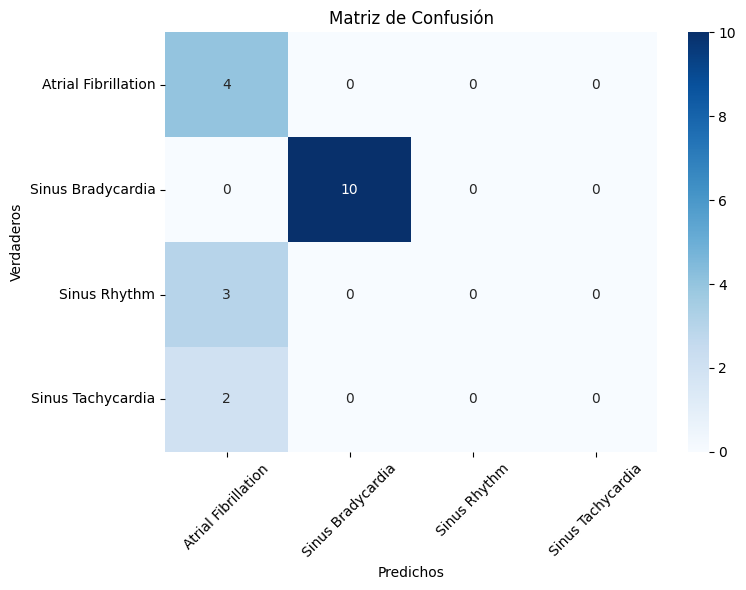

üíæ Modelo guardado como 'ecg_classifier_heart_rate.h5'
üíæ Label encoder guardado


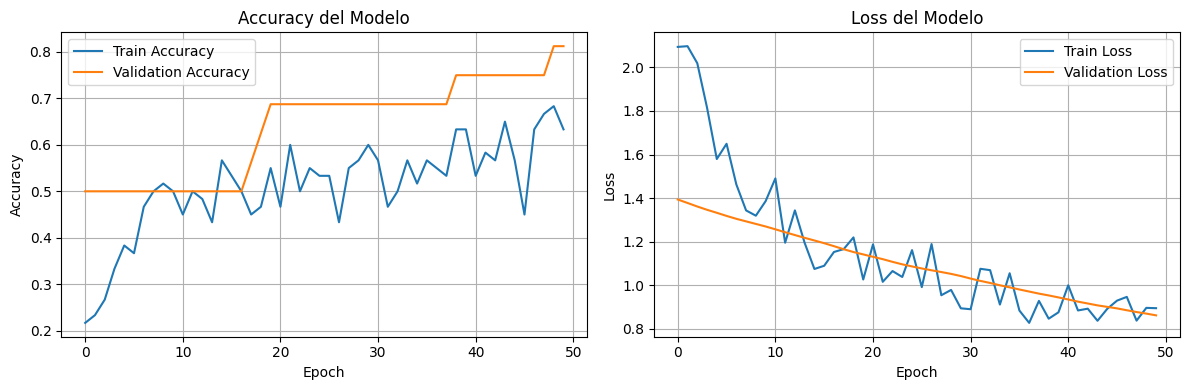


‚úÖ Entrenamiento completado exitosamente!


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

def train_model_heart_rate_features(csv_path):
    """Modelo usando Frecuencia_Cardiaca_Promedio y Rango_cardiaco como features"""
    try:
        df = pd.read_csv(csv_path)
        print(f"Dataset cargado: {len(df)} registros")
    except Exception as e:
        print(f"‚ùå Error cargando CSV: {e}")
        return None, None, None, None, None

    # Columnas necesarias
    required_columns = ['Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco']
    for col in required_columns:
        if col not in df.columns:
            return None, None, None, None, None

    df = df[df['Ritmo_Cardiaco'] != 'Otro'].copy()
    df = df.dropna(subset=required_columns).copy()

    print(f"Registros v√°lidos despu√©s de filtrar: {len(df)}")

    # FEATURES
    X = df[['Frecuencia_Cardiaca_Promedio']].copy()

    X['Rango_cardiaco_encoded'] = df['Rango_cardiaco'].map({'Dentro': 1, 'Fuera': 0})

    y = df['Ritmo_Cardiaco'].copy()


    # Etiquetas de texto a num√©ricas
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Mapeo de clases para referencia
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"üéØ Mapping de clases: {class_mapping}")

    # 4. Escalar features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"üì¶ Dimensiones finales:")
    print(f"Features (X): {X_scaled.shape}")
    print(f"Labels (y): {y_encoded.shape}")

    # Dividir datos
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
    except Exception as e:
        print(f"‚ùå Error dividiendo datos: {e}")
        return None, None, None, None, None

    print(f"\nüéØ Distribuci√≥n de clases en entrenamiento:")
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls_idx, count in zip(unique_classes, counts):
        class_name = label_encoder.inverse_transform([cls_idx])[0]
        print(f"  {class_name}: {count} muestras ({count/len(y_train)*100:.1f}%)")

    # 6. Crear modelo de red neuronal
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        Dropout(0.3),

        Dense(8, activation='relu'),
        Dropout(0.2),

        Dense(len(np.unique(y_encoded)), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("üß† Arquitectura del modelo:")
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # 8. Entrenar modelo
    print("üöÄ Entrenando modelo...")
    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,  # Reducir epochs para prueba
            batch_size=16,  # Reducir batch size
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"‚ùå Error durante el entrenamiento: {e}")
        return None, None, None, None, None

    # 9. Evaluar modelo
    print("üìä Evaluando modelo...")
    try:
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nüéØ Resultados finales:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
    except Exception as e:
        print(f"‚ùå Error evaluando modelo: {e}")
        return model, history, X_test, y_test, label_encoder

    # 10. Predicciones y reporte
    try:
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Convertir n√∫meros de clase back a nombres
        y_true_names = label_encoder.inverse_transform(y_test)
        y_pred_names = label_encoder.inverse_transform(y_pred_classes)

        print("\nüìã Reporte de clasificaci√≥n:")
        print(classification_report(y_true_names, y_pred_names))

        # Matriz de confusi√≥n
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true_names, y_pred_names, labels=label_encoder.classes_)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title('Matriz de Confusi√≥n')
        plt.ylabel('Verdaderos')
        plt.xlabel('Predichos')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

    except Exception as e:
        print(f"‚ö†Ô∏è  Error generando reporte: {e}")

    # 11. Guardar modelo
    try:
        model.save('ecg_classifier_heart_rate.h5')
        print(f"üíæ Modelo guardado como 'ecg_classifier_heart_rate.h5'")

        # Guardar el label encoder
        np.save('label_encoder_classes.npy', label_encoder.classes_)
        print(f"üíæ Label encoder guardado")

    except Exception as e:
        print(f"‚ö†Ô∏è  Error guardando modelo: {e}")

    # 12. Graficar historia de entrenamiento
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy del Modelo')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss del Modelo')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    except Exception as e:
        print(f"‚ö†Ô∏è  Error graficando historia: {e}")

    return model, history, X_test, y_test, label_encoder

# Funci√≥n para diagn√≥stico de datos
def check_dataset(csv_path):
    """Verifica la calidad del dataset"""
    print("üîç Verificando dataset...")
    try:
        df = pd.read_csv(csv_path)
        print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")

        # Verificar columnas requeridas
        required_cols = ['Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco']
        for col in required_cols:
            if col in df.columns:
                print(f"‚úÖ {col}: {df[col].notnull().sum()} valores no nulos")
                if df[col].dtype == 'object':
                    print(f"   Valores √∫nicos: {df[col].unique()}")
            else:
                print(f"‚ùå {col}: NO ENCONTRADA")

        # Mostrar primeras filas
        print("\nüìã Primeras 5 filas:")
        print(df[required_cols].head())

        return True

    except Exception as e:
        print(f"‚ùå Error verificando dataset: {e}")
        return False

# Ejecutar entrenamiento
if __name__ == "__main__":
    # Primero verificar el dataset
    if check_dataset('ecg_classification_dataset.csv'):
        print("\n" + "="*50)
        print("Iniciando entrenamiento...")
        model, history, X_test, y_test, label_encoder = train_model_heart_rate_features('ecg_classification_dataset.csv')